<a href="https://colab.research.google.com/github/kzhangaz/GaussianRegression/blob/main/MultitaskGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Packages
%%capture
!pip install --upgrade gpytorch
!pip install pykeops[full] > install.log

In [ ]:
import math
import torch
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# load data
data = pd.read_csv("/content/ke_data.csv",sep=';',index_col=0,decimal=",")
train_x = data.iloc[0,:].astype(np.float32)
train_y = data.iloc[1:,:].astype(np.float32)

# change the format from dataframe to tensor
train_x = torch.tensor(np.array(train_x))
train_y = torch.tensor(np.array(train_y))
# train_y = torch.reshape(train_y, (-1,))
N = train_x.size(dim=0)
m = len(data)-1

In [ ]:
# define multitask GP model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=m
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=m, rank=1
        )
    # rank???
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=m)
model = MultitaskGPModel(train_x, train_y, likelihood)


In [ ]:
# train model hyperparameters
training_iter = 100

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    # Calc loss and backprop gradients
    # loss = -mll(output, train_y)
    loss = -mll(output, torch.reshape(train_y, (-1,)))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()


Iter 1/100 - Loss: 3.494
Iter 2/100 - Loss: 3.335
Iter 3/100 - Loss: 3.191
Iter 4/100 - Loss: 3.062
Iter 5/100 - Loss: 2.949
Iter 6/100 - Loss: 2.849
Iter 7/100 - Loss: 2.761
Iter 8/100 - Loss: 2.685
Iter 9/100 - Loss: 2.618
Iter 10/100 - Loss: 2.558
Iter 11/100 - Loss: 2.505
Iter 12/100 - Loss: 2.457
Iter 13/100 - Loss: 2.412
Iter 14/100 - Loss: 2.368
Iter 15/100 - Loss: 2.325
Iter 16/100 - Loss: 2.280
Iter 17/100 - Loss: 2.233
Iter 18/100 - Loss: 2.183
Iter 19/100 - Loss: 2.131
Iter 20/100 - Loss: 2.079
Iter 21/100 - Loss: 2.030
Iter 22/100 - Loss: 1.987
Iter 23/100 - Loss: 1.952
Iter 24/100 - Loss: 1.925
Iter 25/100 - Loss: 1.903
Iter 26/100 - Loss: 1.882
Iter 27/100 - Loss: 1.863
Iter 28/100 - Loss: 1.844
Iter 29/100 - Loss: 1.827
Iter 30/100 - Loss: 1.812
Iter 31/100 - Loss: 1.799
Iter 32/100 - Loss: 1.787
Iter 33/100 - Loss: 1.774
Iter 34/100 - Loss: 1.762
Iter 35/100 - Loss: 1.750
Iter 36/100 - Loss: 1.737
Iter 37/100 - Loss: 1.723
Iter 38/100 - Loss: 1.710
Iter 39/100 - Loss: 1

In [ ]:
# make predictions

# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-0.35, 0.35, 101)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()


Text(0.5, 1.0, 'Observed Values (Likelihood)')

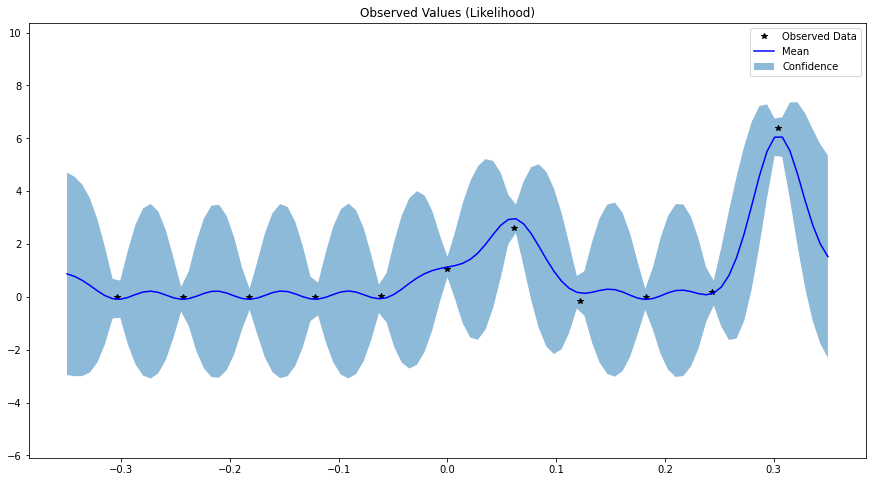

In [ ]:

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(15, 8))

i = 7
# Plot training data as black stars
ax.plot(train_x.detach().numpy(), train_y[:, i-1].detach().numpy(), 'k*')
# Predictive mean as blue line
ax.plot(test_x.numpy(), mean[:, i-1].numpy(), 'b')
# Shade in confidence
ax.fill_between(test_x.numpy(), lower[:, i-1].numpy(), upper[:, i-1].numpy(), alpha=0.5)
ax.set_ylim([min(lower[:, i-1].numpy())-3, max(upper[:, i-1].numpy())+3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])
ax.set_title('Observed Values (Likelihood)')


In [ ]:
min(train_x),max(train_x)

(tensor(-0.3043), tensor(0.3043))